# Coaccessibility

For this Notebook we will use <a href=https://cole-trapnell-lab.github.io/cicero-release/docs_m3/>Cicero</a>. Cicero's main function is to use scATAC-seq data to predict cis-regulatory interactions (such as the interaction between enhancers and promoters) in terms of co-accessibility. For more details about Cicero, see <a href=https://cole-trapnell-lab.github.io/cicero-release/papers/> these papers</a>.

In [1]:
library(cicero)
library(monocle3)
library(ggplot2)
library(patchwork)
library(stringr)
library(SeuratWrappers)
library(Signac)
library(Seurat)
set.seed(1234)

Loading required package: monocle3

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes conta

## 0. Load Data 

To run cicero, we need the data from the previous notebook and a file that contains the lengths of each of the chromosomes from the species genome. <br>
For mouse (*mus musculus*), the file *mm10_chromosome_length.txt* is included in the <a href=https://github.com/morris-lab/CellOracle/tree/master/docs/notebooks/01_ATAC-seq_data_processing/option1_scATAC-seq_data_analysis_with_cicero>celloracle notebook folder</a>. For a different reference genome, see <a href=https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero>Cicero documentation</a>.

For visualization, we also need the genome annotation from Ensembl. To download the info for the mouse, see: http://www.ensembl.org/Mus_musculus/Info/Index.

In [2]:
#Load data from previous notebook.
brain <- readRDS("./adult_mouse_brain/Outputs/brain_imputation.rds")
DefaultAssay(brain) <- 'ATAC'
brain

An object of class Seurat 
184181 features across 3512 samples within 3 assays 
Active assay: ATAC (157203 features, 157203 variable features)
 2 other assays present: ACTIVITY, RNA
 2 dimensional reductions calculated: lsi, umap

In [3]:
#Load reference genome information
chromosome_length <- read.table("./adult_mouse_brain/Inputs/mm10_chromosome_length.txt")

In [4]:
#Load gene annotation
gene_anno <- rtracklayer::readGFF("./adult_mouse_brain/Inputs/Mus_musculus.GRCm39.103.gtf.gz")
# rename some columns to match requirements
gene_anno$chromosome <- paste0("chr", gene_anno$seqid)
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_id
gene_anno$symbol <- gene_anno$gene_name

## 1. Create Cicero CDS

To estimate co-accessibility accurately, we need a more dense count data than the sparse data directly scATAC-seq. That is why Cicero aggregates similar cells using KNN based on their coordinates in a lower dimension map, like UMAP. This final dataset is a cicero cds object.

In [5]:
brain_cds <- as.cell_data_set(x=brain) 
brain_cicero <- make_cicero_cds(brain_cds, reduced_coordinates = reducedDims(brain_cds)$UMAP)

Warning message:
"Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object"
Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 0.887970669837495
Median shared cells bin-bin: 0



## 2. Run Cicero
Cicero computes the correlations in adjusted accessibilities between all pairs of sites within 500 kb. They use **Graphical LASSO** <a href=https://pubmed.ncbi.nlm.nih.gov/18079126/>(Friedman et al., 2008)</a>, which estimates regularized correlation matrices. Cicero penalizes correlations according to distance, favouring regions that are closer to each other. The output of Cicero are the co-accessibility scores for all pairs of sites within 500 kb of one another.

run_cicero is equivalent to run these functions:
* __estimate_distance_parameter:__ calculates the distance scaling parameter used to adjust the distance-based penalty function used in Cicero's model calculation.
* __generate_cicero_models:__ fits <a href=https://towardsdatascience.com/porting-ideas-to-math-a-step-by-step-derivation-of-graphical-lasso-2e01f7165d95>glasso</a>.
* __assemble_connections:__ assembles the connections into a data frame with cicero co-accessibility scores. Checks for concordance.

In [6]:
conns <- run_cicero(brain_cicero, chromosome_length) # Takes a few minutes to run
head(conns)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  9665"
[1] "Other models: "

Zero or one element in range 
                        1296 
[1] "Models with errors:  0"
[1] "Done"


,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr1-100016342-100016776,chr1-99760025-99760424,-0.0716256
2,chr1-100016342-100016776,chr1-99771992-99774603,0.4021592
3,chr1-100016342-100016776,chr1-99781297-99782114,0.4051374
4,chr1-100016342-100016776,chr1-99858072-99858232,0.3965187
5,chr1-100016342-100016776,chr1-99872284-99873537,0.2268466
6,chr1-100016342-100016776,chr1-99877826-99878253,0.0115850


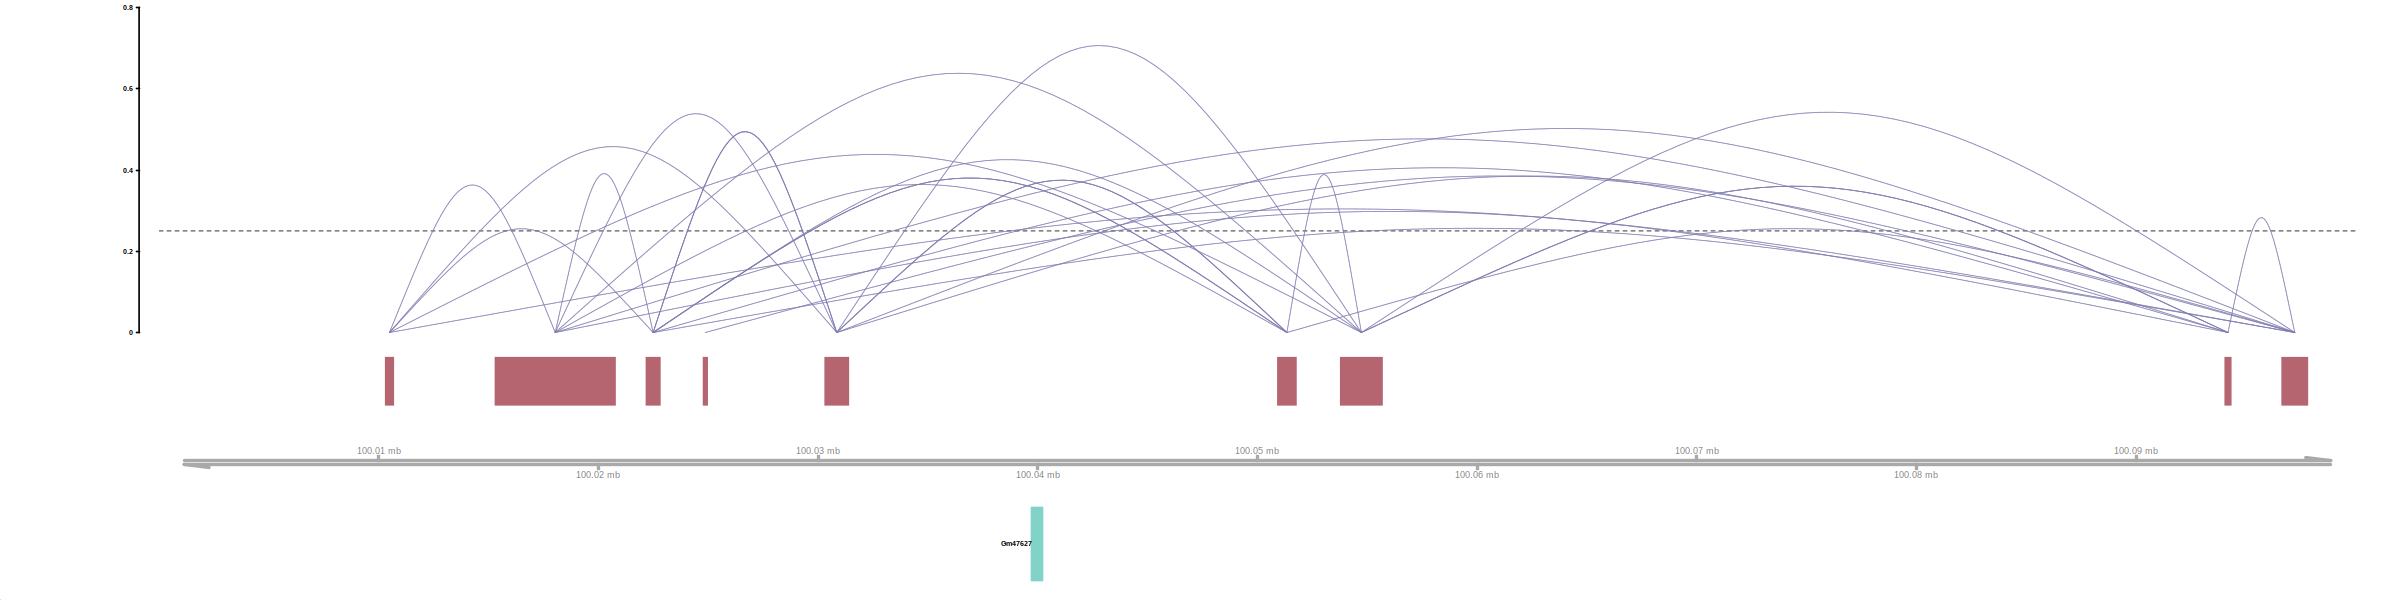

In [7]:
#visualize connections
options(repr.plot.width=20, repr.plot.height=5)
plot_connections(conns, "chr10", 100000000, 100100000,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .25, 
                 connection_width = .5, 
                 collapseTranscripts = "longest")

## 3. Finding cis-Co-accessibility Networks (CCANS)

In addition to pairwise co-accessibility scores, Cicero also has a function to find Cis-Co-accessibility Networks (CCANs), which are modules of sites that are highly co-accessible with one another. We use the Louvain community detection algorithm (Blondel et al., 2008) to find clusters of sites that tended to be co-accessible.

In [8]:
ccans <- cicero::generate_ccans(conns)

[1] "Coaccessibility cutoff used: 0.62"


In [9]:
head(ccans)

,Peak,CCAN
,<chr>,<dbl>
chr1-10037298-10040644,chr1-10037298-10040644,573
chr1-10141158-10142473,chr1-10141158-10142473,570
chr1-10247333-10248082,chr1-10247333-10248082,570
chr1-10286764-10287184,chr1-10286764-10287184,8
chr1-104652448-104652854,chr1-104652448-104652854,3
chr1-104754345-104755040,chr1-104754345-104755040,4


Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_rect)."
Warning message:
"Removed 1 rows containing missing values (geom_rect)."


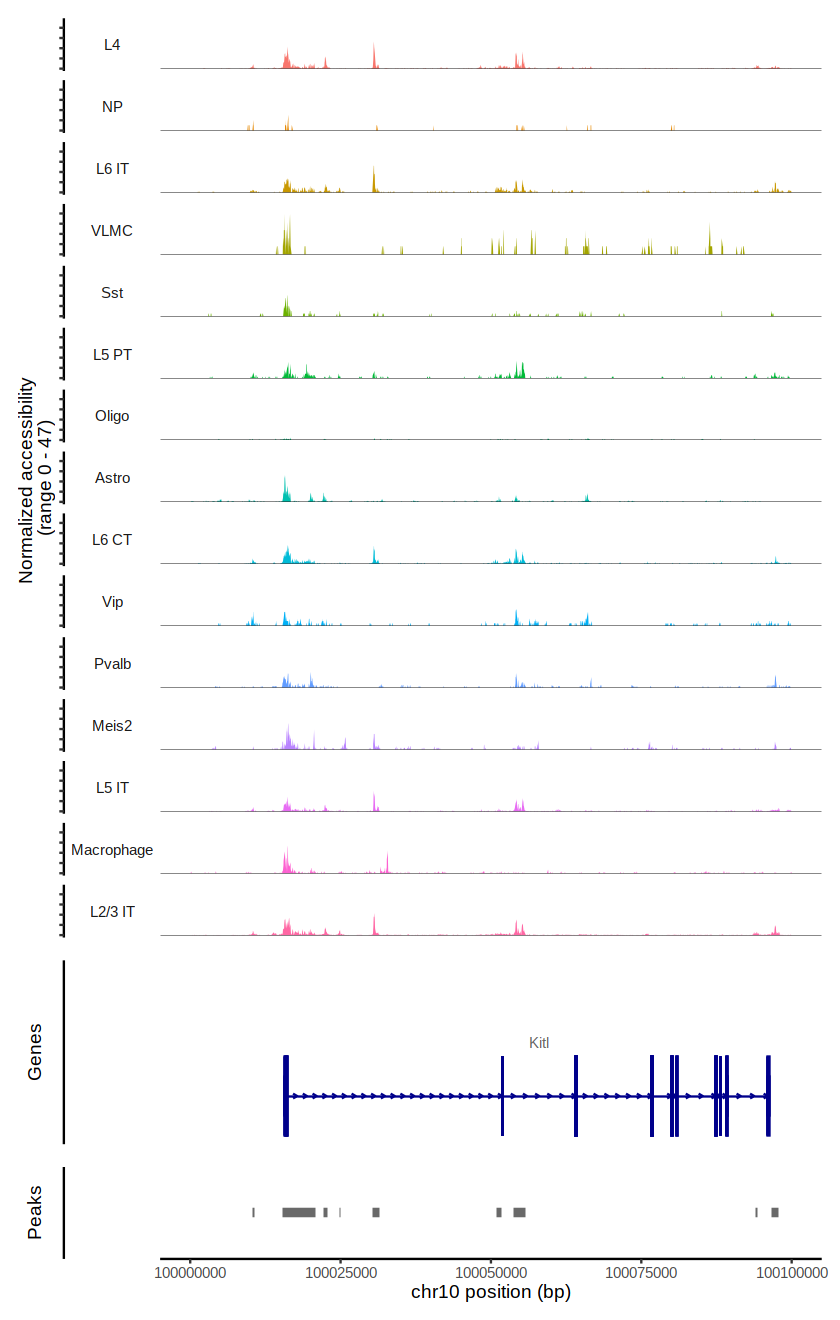

In [10]:
options(repr.plot.width=7, repr.plot.height=11)
CoveragePlot(brain, region = "chr10-100000000-100100000")

## 4. Save outputs

In [11]:
#save conns and ccans #from here we can get the output for the second notebook in CellOracle
saveRDS(conns, file = "./adult_mouse_brain/Outputs/conns.rds")
saveRDS(ccans, file = "./adult_mouse_brain/Outputs/ccans.rds")

In [15]:
all_peaks <- row.names(exprs(brain_cds))
write.csv(x = all_peaks, file = "./adult_mouse_brain/Outputs/all_peaks.csv")
write.csv(x = conns, file = "./adult_mouse_brain/Outputs/cicero_connections.csv")

In [16]:
#add links to a Seurat object
links <- ConnectionsToLinks(conns=conns, ccans=ccans)
Links(brain) <- links

In [17]:
#save Seurat object
saveRDS(brain, file = "./adult_mouse_brain/Outputs/brain_coaccs.rds")